In [227]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

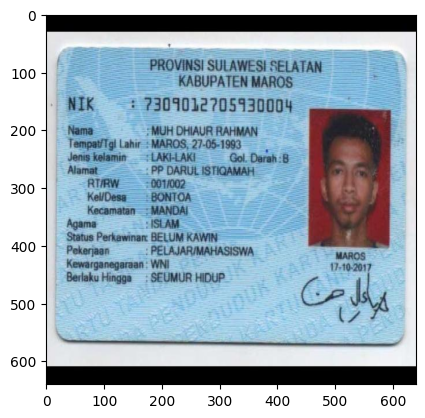

In [239]:
image_path = r"/home/wawanwidiantara/Code/py_code/KTP-Information-Extraction-App/data/train/images/246-ktp_jpg.rf.fa9bf940931b0387b060f828f5ba6f8e.jpg"

# Convert image to RGB
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [229]:
from doctr.models import ocr_predictor
from doctr.io import DocumentFile

In [230]:
model = ocr_predictor(det_arch='fast_small',reco_arch='crnn_mobilenet_v3_small',pretrained=True)

DEBUG:tensorflow:Layer lstm_40 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_40 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_40 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_41 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_41 will use cuDNN kernels when running on GPU.
DEBUG:tensorflow:Layer lstm_41 will use cuDNN kernels when running on GPU.


In [240]:
single_img_doc = DocumentFile.from_images(image_path)
result = model(single_img_doc)
export = result.export()

In [241]:
def extract_objectness_scores(blocks):
    scores = []
    for block in blocks:
        scores.append(block.get('objectness_score', 0))
        if 'lines' in block:
            for line in block['lines']:
                scores.append(line.get('objectness_score', 0))
                if 'words' in line:
                    for word in line['words']:
                        scores.append(word.get('objectness_score', 0))
        if 'words' in block:
            for word in block['words']:
                scores.append(word.get('objectness_score', 0))
    return scores

# Extract scores
scores = extract_objectness_scores(export['pages'][0]['blocks'])

# Calculate average
average_score = sum(scores) / len(scores) if scores else 0
average_score

0.8119623338275493

In [242]:
import numpy as np

class OCRTextProcessor:
    def __init__(self, tolerance=15):
        self.tolerance = tolerance
    
    def process_ocr_result(self, result):
        """Process OCR result and return corrected text alignments."""
        # Extract all words with their coordinates and text
        words = []
        for page in result['pages']:
            for block in page['blocks']:
                for line in block.get('lines', []):
                    for word in line.get('words', []):
                        # Get coordinates from geometry
                        coords = word['geometry']
                        # Convert coordinates to more readable format
                        x1, y1 = coords[0]
                        x2, y2 = coords[1]
                        
                        words.append({
                            'text': word['value'],
                            'coords': {
                                'y1': float(y1),
                                'y2': float(y2),
                                'x1': float(x1),
                                'x2': float(x2)
                            }
                        })
        
        # Sort words by y-coordinate first
        words.sort(key=lambda x: x['coords']['y1'])
        
        # Group words that are on the same line
        lines = []
        current_line = [words[0]] if words else []
        
        for word in words[1:]:
            last_word = current_line[-1] if current_line else None
            
            if last_word and self._is_same_line(last_word['coords'], word['coords']):
                current_line.append(word)
            else:
                if current_line:
                    # Sort words in the line by x-coordinate before adding to lines
                    current_line.sort(key=lambda x: x['coords']['x1'])
                    lines.append(current_line)
                current_line = [word]
        
        if current_line:
            # Sort the last line by x-coordinate
            current_line.sort(key=lambda x: x['coords']['x1'])
            lines.append(current_line)
        
        # Convert grouped words to text
        formatted_text = []
        for line in lines:
            line_text = ' '.join(word['text'] for word in line)
            formatted_text.append(line_text)
        
        return formatted_text
    
    def _is_same_line(self, coords1, coords2, tolerance_factor=0.5):
        """
        Check if two words are on the same line based on vertical coordinates
        Using a tolerance factor relative to text height
        """
        height1 = coords1['y2'] - coords1['y1']
        height2 = coords2['y2'] - coords2['y1']
        avg_height = (height1 + height2) / 2
        
        mid1 = (coords1['y1'] + coords1['y2']) / 2
        mid2 = (coords2['y1'] + coords2['y2']) / 2
        
        return abs(mid1 - mid2) < (avg_height * tolerance_factor)

# Example usage
def process_id_card(ocr_result):
    processor = OCRTextProcessor()
    formatted_text = processor.process_ocr_result(ocr_result)
    return formatted_text

In [243]:
class TextEntityExtractor:
    def __init__(self):
        # Define fields with their keywords and tolerance levels
        self.fields = [
            {'name': 'provinsi', 'keywords': ['provinsi'], 'tolerance': 2},
            {'name': 'kabupaten', 'keywords': ['kabupaten', 'kota'], 'tolerance': 2},
            {'name': 'nik', 'keywords': ['nik'], 'tolerance': 1},
            {'name': 'nama', 'keywords': ['nama'], 'tolerance': 1},
            {'name': 'tempat_tgl_lahir', 'keywords': ['tempat/tgl', 'tempat/tgilahir', 'tempat','tompat/tgllah'], 'tolerance': 3},
            # {'name': 'tanggal_lahir', 'keywords': ['tgl', 'tanggal'], 'tolerance': 2},
            {'name': 'jenis_kelamin', 'keywords': ['jenis kelamin', 'kelamin'], 'tolerance': 2},
            {'name': 'alamat', 'keywords': ['alamat'], 'tolerance': 2},
            {'name': 'rt_rw', 'keywords': ['rt/rw', 'rtrw'], 'tolerance': 2},
            {'name': 'kel_desa', 'keywords': ['kel/desa', 'kelurahan', 'desa'], 'tolerance': 2},
            {'name': 'kecamatan', 'keywords': ['kecamatan', 'kec'], 'tolerance': 3},
            {'name': 'agama', 'keywords': ['agama'], 'tolerance': 2},
            {'name': 'status_perkawinan', 'keywords': ['status perkawinan', 'perkawinan'], 'tolerance': 3},
            {'name': 'pekerjaan', 'keywords': ['pekerjaan', 'kerja'], 'tolerance': 3},
            {'name': 'kewarganegaraan', 'keywords': ['kewarganegaraan'], 'tolerance': 4},
            {'name': 'berlaku_hingga', 'keywords': ['berlaku hingga', 'hingga'], 'tolerance': 3}
        ]

    def levenshtein_distance(self, s1, s2):
        """Calculate the Levenshtein distance between two strings"""
        if len(s1) < len(s2):
            return self.levenshtein_distance(s2, s1)

        if len(s2) == 0:
            return len(s1)

        previous_row = range(len(s2) + 1)
        for i, c1 in enumerate(s1):
            current_row = [i + 1]
            for j, c2 in enumerate(s2):
                insertions = previous_row[j + 1] + 1
                deletions = current_row[j] + 1
                substitutions = previous_row[j] + (c1 != c2)
                current_row.append(min(insertions, deletions, substitutions))
            previous_row = current_row

        return previous_row[-1]

    def find_field_match(self, line):
        """Find matching field for a line based on Levenshtein distance"""
        words = line.lower().split()
        if not words:
            return None

        best_match = None
        min_distance = float('inf')
        
        for field in self.fields:
            for keyword in field['keywords']:
                keyword_parts = keyword.lower().split()
                
                # Try matching with first word(s) of line
                for i in range(min(len(words), len(keyword_parts) + 1)):
                    line_part = ' '.join(words[:i+1])
                    distance = self.levenshtein_distance(line_part, keyword)
                    
                    if distance < min_distance and distance <= field['tolerance']:
                        min_distance = distance
                        best_match = field

        return best_match

    def extract_value(self, line, field):
        """Extract value from a line based on field type"""
        # Split line into parts
        parts = line.split()
        
        # Find where the field name ends
        field_end = 0
        for i, part in enumerate(parts):
            for keyword in field['keywords']:
                if self.levenshtein_distance(part.lower(), keyword.lower()) <= field['tolerance']:
                    field_end = i + 1
                    break
        
        # Extract value portion
        value = ' '.join(parts[field_end:]).strip()
        
        # Clean up common artifacts
        value = value.replace(':', '').strip()
        
        return value if value else None

    def extract_entities(self, lines):
        """Extract entities from list of lines"""
        entities = {}
        
        for line in lines:
            # Skip empty lines
            if not line.strip():
                continue
            
            # Find matching field
            field = self.find_field_match(line)
            if field:
                value = self.extract_value(line, field)
                if value:
                    # Special handling for fields that might have multiple parts
                    if field['name'] in entities:
                        if isinstance(entities[field['name']], list):
                            entities[field['name']].append(value)
                        else:
                            entities[field['name']] = [entities[field['name']], value]
                    else:
                        entities[field['name']] = value

        return entities

# Example usage
def extract_id_card_info(lines):
    extractor = TextEntityExtractor()
    return extractor.extract_entities(lines)

In [244]:
# Using the processor
processor = OCRTextProcessor()
formatted_text = processor.process_ocr_result(export)

def preprocess_text(text):
    # Convert to uppercase
    text = text.upper()
    # Remove single characters
    text = ' '.join(word for word in text.split() if len(word) > 1)
    # Remove leading and trailing spaces
    text = text.strip()
    return text

# Apply preprocessing to each string in the list
processed_data = [preprocess_text(item) for item in formatted_text]
processed_data = [item for item in processed_data if item]

processed_data

['PROVINSI SULAWESI SELATAN',
 'KABUPATEN MAROS',
 'NIK 7301032705130004',
 'NAMA MUH DHIAUR RAHMAN',
 'TAMPAT/TGL LAHIR MAROS, 27-05 1993',
 'JENIS KELAMIN LAK-LAKI GOL: DARAH:B',
 'ALAMAT PP DARUL ISTIQAMAH',
 'RT/RW 001/002',
 'KEL/DESA BONTOA',
 'KECAMATAN MANDAI',
 'AGAMA ISLAM',
 'STATUS PERKAWINAN: BELUM KAWIN',
 'PEKERJAAN PELAJAPMAHASISWA',
 'MAROS',
 'KEWARGANEGERAAN WNI',
 '17-10-2017',
 'BERLAKU HINGGA SEUMUR HIDUP']

In [245]:
entities = extract_id_card_info(processed_data)
def post_processing(data):
    import re
    
    # 1. Update `jenis_kelamin`
    data['jenis_kelamin'] = 'Laki-laki' if data['jenis_kelamin'].startswith('L') else 'Perempuan'
    
    # 2. Update `agama`
    data['agama'] = data['agama'].split()[0]
    
    # 3. Update `status_perkawinan`
    data['status_perkawinan'] = re.sub(r'\d+', '', data['status_perkawinan']).strip()
    
    return data

result = post_processing(entities)
result

{'provinsi': 'SULAWESI SELATAN',
 'kabupaten': 'MAROS',
 'nik': '7301032705130004',
 'nama': 'MUH DHIAUR RAHMAN',
 'tempat_tgl_lahir': 'LAHIR MAROS, 27-05 1993',
 'jenis_kelamin': 'Laki-laki',
 'alamat': 'PP DARUL ISTIQAMAH',
 'rt_rw': '001/002',
 'kel_desa': 'BONTOA',
 'kecamatan': 'MANDAI',
 'agama': 'ISLAM',
 'status_perkawinan': 'BELUM KAWIN',
 'pekerjaan': 'PELAJAPMAHASISWA',
 'kewarganegaraan': 'WNI',
 'berlaku_hingga': 'SEUMUR HIDUP'}

In [237]:
# here the result:
# provinsi: JAWA TENGAH kabupaten: . PURBALINGGA nik: - 330315040458000 nama: IFTAH SADJAD AHMADI tempat_lahir: PURBAUNGGA tanggal_lahir: 04-06-1998 jenis_kelamin: LAKRAKE Gol Darah a alamat: PERLMEDMIPAOAMMAGNFS rt_rw: 001003 kel_desa: BOJANEGARA kecamatan: PADAMARA agama: ISLAM status_perkawinan: BELUMKAWIN PUHBALINGGA pekerjaan: PELLARMAHASISHA 19092015 kewarganegaraan: WNI berlaku_hingga: SEUMUR RIDUP

# do validation like:
# 1. there is no number in "pekerjaan", so if there is detected number, remove the number
# 2. in status perkawinan mostly the value is : belum kawin, kawin, cerai mati, cerai hidup. check if tolerance in that value. in my case it detected BELUMKAWIN PUHBALINGGA. remove else the value i gave you earlier (PUHBALINGGA)
# 3. Gol darah is completly new key